In [9]:
import kagglehub
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import textstat

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ronak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

# load datasets
df=pd.read_csv(path+'/WELFake_Dataset.csv')
df.head()

Path to dataset files: C:\Users\ronak\.cache\kagglehub\datasets\saurabhshahane\fake-news-classification\versions\77


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
df.shape

(72134, 4)

In [4]:
df['article'] = df['title'] + df['text']
df = df[['article', 'label']]
df.head()

,article,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,NaN,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,1


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(subset='article', inplace=True)
df.shape

(63121, 2)

In [6]:
df['sentiment_polarity'] = df['article'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['article'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [7]:
df.head()

,article,label,sentiment_polarity,sentiment_subjectivity
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,0.034641,0.296824
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,0.190402,0.512798
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0,0.111493,0.387106
4,SATAN 2: Russia unvelis an image of its terrif...,1,0.013342,0.403577
5,About Time! Christian Group Sues Amazon and SP...,1,-0.100461,0.428571


In [8]:
df['word_count'] = df['article'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['article'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)
df['sentence_count'] = df['article'].apply(lambda x: len(str(x).split('.')))
df['unique_word_count'] = df['article'].apply(lambda x: len(set(str(x).split())) / len(str(x).split()))


In [10]:
df['flesch_reading_ease'] = df['article'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df['exclamation_count'] = df['article'].apply(lambda x: str(x).count('!'))
df['question_count'] = df['article'].apply(lambda x: str(x).count('?'))

In [ ]:
df.head()

,article,label,sentiment_polarity,sentiment_subjectivity,word_count,char_count,avg_word_length,sentence_count,unique_word_count,flesch_reading_ease,exclamation_count,question_count
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,0.034641,0.296824,888,5179,5.825647,55,0.494369,72.56,2,7
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,0.190402,0.512798,52,353,6.660377,2,0.942308,45.09,1,0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0,0.111493,0.387106,1336,8115,6.069559,61,0.520210,56.59,0,1
4,SATAN 2: Russia unvelis an image of its terrif...,1,0.013342,0.403577,344,2011,5.828986,12,0.584302,51.21,0,0
5,About Time! Christian Group Sues Amazon and SP...,1,-0.100461,0.428571,256,1608,6.256809,12,0.648438,59.94,2,0


# preprocessing

In [13]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    text = re.sub(r'\b([a-zA-Z])\.(?=[a-zA-Z])', r'\1specialdot', text)  # Preserve acronyms
    text = re.sub(r'\b([a-zA-Z])\.(?=\s|$)', r'\1specialdot', text)
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.replace("specialdot", ".")
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    stop_words.discard("not")
    stop_words.discard("no")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Vectorize text
def vectorize(text, maxFeats, ngram):
    vectorizer = TfidfVectorizer(max_features=maxFeats, ngram_range=ngram, stop_words='english')
    X_tfidf = vectorizer.fit_transform(text)
    return X_tfidf, vectorizer

# Load data
X_train, X_test, y_train, y_test = train_test_split(
    df[['article','sentiment_polarity','sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']], df['label'], 
    test_size=0.2, random_state=42, stratify=df['label']
)

# Preprocess data
X_train_processed = X_train['article'].apply(preprocess_text)
X_test_processed = X_test['article'].apply(preprocess_text)

# Vectorize data
X_train_vectorized, vectorizer = vectorize(X_train_processed, 2000, (1,1))
X_test_vectorized = vectorizer.transform(X_test_processed)




In [14]:
train_vectorized_df = pd.DataFrame(X_train_vectorized)
X_train_df = pd.concat([train_vectorized_df.reset_index(drop=True), X_train[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']].reset_index(drop=True)], axis=1)
test_vectorized_df = pd.DataFrame(X_test_vectorized)
X_test_df = pd.concat([test_vectorized_df.reset_index(drop=True), X_test[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']].reset_index(drop=True)], axis=1)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [16]:
from scipy.sparse import vstack

In [18]:
train_sparse_matrix = vstack(X_train_df.iloc[:,0])
train_dense_array = train_sparse_matrix.toarray()
train_tensor_dense_array = torch.tensor(train_dense_array,dtype=torch.float32)

train_numeric_df = X_train_df[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']]
train_data_array = train_numeric_df.to_numpy()
train_data_tensor = torch.tensor(train_data_array,dtype=torch.float32)
## Need to add train_data_tensor to the end of train_tensor_dense_array

train_combined_tensor = torch.cat([train_tensor_dense_array,train_data_tensor],dim=1)


test_sparse_matric = vstack(X_test_df.iloc[:,0])
test_dense_array = test_sparse_matric.toarray()
test_tensor_dense_array = torch.tensor(test_dense_array,dtype=torch.float32)

test_numeric_df = X_test_df[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']]
test_data_array = test_numeric_df.to_numpy()
test_data_tensor = torch.tensor(test_data_array,dtype=torch.float32)

test_combined_tensor = torch.cat([test_tensor_dense_array,test_data_tensor], dim=1)




y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)



In [19]:
import matplotlib.pyplot as plt

In [40]:

# Create DataLoader for batching
train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

def accuracy_score(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            predictions = (outputs >= 0.5).float()
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()
    return (correct / total)

# Define the neural network
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Initialize the model
input_dim = train_combined_tensor.shape[1]
model = FakeNewsClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epoch_levels = [5,10,15,20,30]
accuracy_values =  []


for epochs in epoch_levels:
    model = FakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    accuracy = accuracy_score(model, test_loader)
    accuracy_values.append(accuracy)


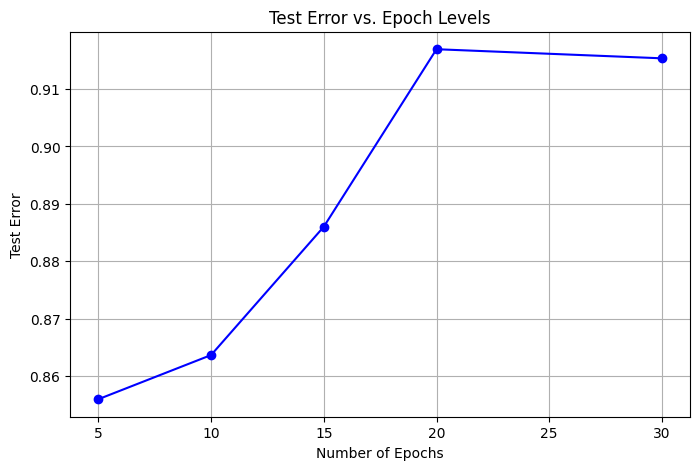

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(epoch_levels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Test Error vs. Epoch Levels')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Error')
plt.grid()
plt.show()

In [44]:
train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class ComplexFakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ComplexFakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(128,64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

# Initialize the model
input_dim = train_combined_tensor.shape[1]
model = ComplexFakeNewsClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epoch_levels = [5,10,15,20,30]
accuracy_values =  []


for epochs in epoch_levels:
    model = ComplexFakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    accuracy = accuracy_score(model, test_loader)
    accuracy_values.append(accuracy)



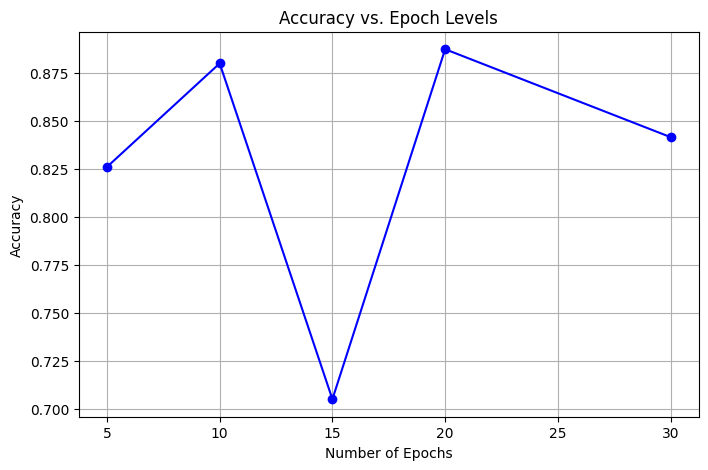

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(epoch_levels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Epoch Levels')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# testing

In [12]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

# load datasets
fake=pd.read_csv(path+'/fake.csv')
fake['label'] = 0
true=pd.read_csv(path+'/true.csv')
true['label'] = 1
test = pd.concat([fake, true])
test.head()

100%|██████████| 41.0M/41.0M [00:01<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: C:\Users\ronak\.cache\kagglehub\datasets\bhavikjikadara\fake-news-detection\versions\1


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [13]:
test['article'] = test['title'] + test['text']
test = test[['article', 'label']]

In [14]:
test.dropna(inplace=True)
test.drop_duplicates(subset='article', inplace=True)
test.shape

(39105, 2)

In [15]:
test['sentiment_polarity'] = test['article'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
test['sentiment_subjectivity'] = test['article'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
test.head()

,article,label,sentiment_polarity,sentiment_subjectivity
0,Donald Trump Sends Out Embarrassing New Year’...,0,0.083136,0.597204
1,Drunk Bragging Trump Staffer Started Russian ...,0,-0.020811,0.344802
2,Sheriff David Clarke Becomes An Internet Joke...,0,-0.012345,0.541969
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,-0.038021,0.413021
4,Pope Francis Just Called Out Donald Trump Dur...,0,-0.011722,0.495222


In [27]:
test['label'] = 1 - test['label']

In [28]:
test.head()

,article,label,sentiment_polarity,sentiment_subjectivity
0,Donald Trump Sends Out Embarrassing New Year’...,1,0.083136,0.597204
1,Drunk Bragging Trump Staffer Started Russian ...,1,-0.020811,0.344802
2,Sheriff David Clarke Becomes An Internet Joke...,1,-0.012345,0.541969
3,Trump Is So Obsessed He Even Has Obama’s Name...,1,-0.038021,0.413021
4,Pope Francis Just Called Out Donald Trump Dur...,1,-0.011722,0.495222


In [29]:
X, y = test['article'], test['label']
X = X.apply(preprocess_text)
X = vectorizer.transform(X)
# Predict and evaluate on test set
# print(classification_report(y, y_pred))
# print(f"Test Set Accuracy: {accuracy_score(y, y_pred)}")

In [31]:

X_test_tensor1 = torch.tensor(X.toarray(),dtype=torch.float32)
y_test_tensor1 = torch.tensor(y.values,dtype=torch.float32)

test_dataset1 = TensorDataset(X_test_tensor1,y_test_tensor1)
test_loader1 = DataLoader(test_dataset1,batch_size=32)


# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader1:
        outputs = model(X_batch).squeeze()
        predictions = (outputs >= 0.5).float()
        total += y_batch.size(0)
        correct += (predictions == y_batch).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9947
